# Trying to use RRT to represent a photograph

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image
from IPython.display import display

../../photo.jpg


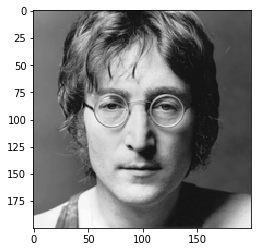

In [6]:
def loadImage(fileName, targetSize=(100,200)):
    '''
    targetSize: will be downsampled to this (y,x). The smallest of dimensions defines the output size.
    '''
    print(fileName)
    im = Image.open(fileName)

    im.thumbnail(targetSize, Image.ANTIALIAS)
    # im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    im = im.convert('RGB')
    # display(im) # Faithful representation
    return im

img = loadImage('../../photo.jpg' , (200,400))
plt.imshow(img);

In [55]:
def image_to_data(im):
    y = np.array(im)
    (h,w,_) = y.shape
    y = np.mean(y.reshape((h*w,3)), axis=1)
    _x,_y = np.meshgrid(np.array(range(w))/w, np.array(range(h))/h)
    x = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    x[:,1] = 1-x[:,1]
    return (x,y)

imgxy, imgz = image_to_data(im)

In [64]:
def sample_points(xy, z, n=1):
    p = np.max(z)-z
    p = p/np.sum(p)
    out = xy[np.random.choice(list(range(xy.shape[0])), p=p, size=n),:]
    if n==1:
        out = out[0]
    #print(out)
    return out
    
sample_points(imgxy, imgz, n=1)

array([0.29 , 0.885])

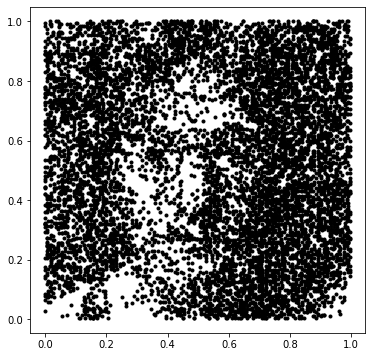

In [65]:
points = sample_points(imgxy, imgz, 10000)
plt.figure(figsize=(6,6))
plt.plot(points[:,0], points[:,1], 'k.');

...................

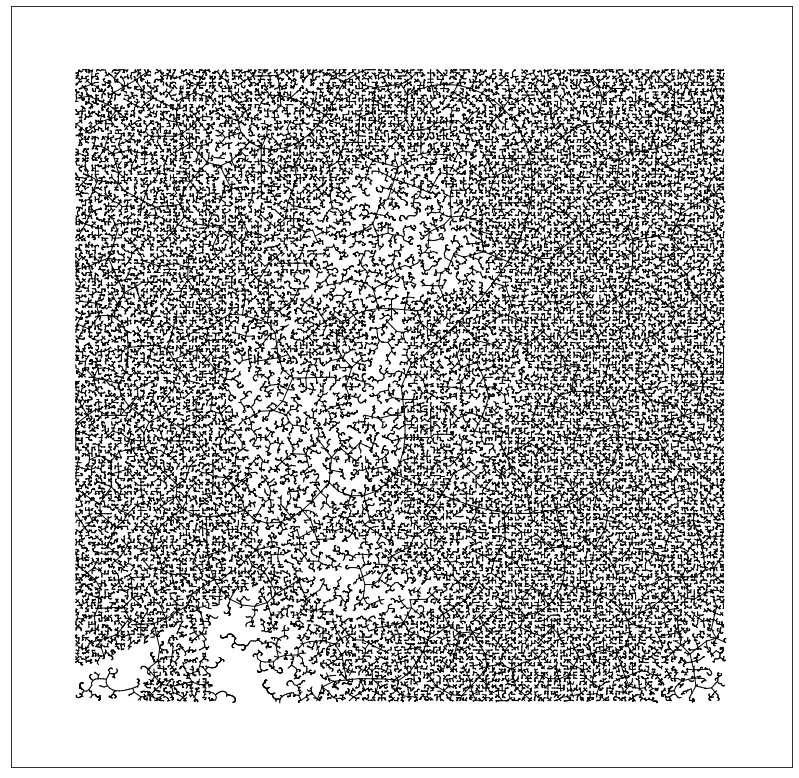

In [69]:
SEED = [0.5, 0.5]
N_POINTS = 100000
STEP_INITIAL = 0.02
STEP_DECREMENT = 0.8
MAX_FAILS = 10
CLOSE_PATHS = False
CURVE_TYPE = 'hook' # none, hook, or slide

tree = np.array(SEED, ndmin=2)

def nearest(tree,xy):
    dist2 = np.square(tree[:,0]-xy[0]) + np.square(tree[:,1]-xy[1])
    best = np.argmin(dist2)
    return (best,dist2[best])
    
fig = plt.figure(figsize=(14,14))
ax = plt.subplot(111)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks=[])
plt.yticks(ticks=[])

def rot(alpha):
    return np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])

count_failures = 0
step = STEP_INITIAL
current_width = 1
for i in range(N_POINTS):
    threshold = (step**2)/2                     # Collision threshold
    #target = np.random.uniform(low=0, high=1, size=2)
    target = sample_points(imgxy, imgz, 1)
    
    best,_ = nearest(tree,target)    
    s = tree[best,:]
    vect = [target[0]-s[0], target[1]-s[1]]
    d = np.linalg.norm(vect)
    nsteps = int(d/step)
    vect = vect/d*step
    angle_coeff = 2*np.pi/(nsteps**2+1) # Presumably terminates at almost backwards
    angle_sign = 1 if np.random.uniform()>0.5 else -1
    if CURVE_TYPE == "slide":
        vect = np.matmul(rot(angle_sign*np.pi/2*step/STEP_INITIAL),vect)
        
    line = None
    for i in range(nsteps):
        old = s
        s = s+vect
        if CURVE_TYPE == "hook":
            vect = np.matmul(rot(angle_sign*i*angle_coeff),vect)
        elif CURVE_TYPE == 'slide':
            temp = i**2/nsteps**2
            vect = vect*(1-temp) + np.array([target[0]-s[0], target[1]-s[1]])*temp
            
        if s[0]<0 or s[0]>1 or s[1]<0 or s[1]>1:
            break
        (closest,d2) = nearest(tree,s)
        if d2<= threshold:
            if CLOSE_PATHS:
                line = np.vstack((line,tree[closest,:]))
                ax.plot([old[0],s[0]], [old[1],s[1]], 'k-', linewidth = current_width)
            break
        if line is None:
            line = s
        else:
            line = np.vstack((line,s))
        ax.plot([old[0],s[0]], [old[1],s[1]], 'k-', linewidth = current_width)
    
    if line is None:
        count_failures += 1
    else:
        tree = np.vstack((tree,line))
        count_failures = 0
        
    if count_failures == MAX_FAILS: # Time to go more fine-grain
        step *= STEP_DECREMENT
        #current_width *= STEP_DECREMENT
        print('.',end='')
    if i % 1000 == 0:
        print(i, end=' ')